In [51]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
# 1. Загрузка и переработка данных
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразование изображений в тензоры
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация
])

In [29]:
# Загрузка датасета SVHN
train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

100%|██████████| 182040794/182040794 [00:44<00:00, 4123242.77it/s]


100%|██████████| 64275384/64275384 [00:16<00:00, 3850928.01it/s]


In [30]:
# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
# 2. Визуализация нескольких примеров из тренировочного набора
dataiter = iter(train_loader)
images, labels = next(dataiter)

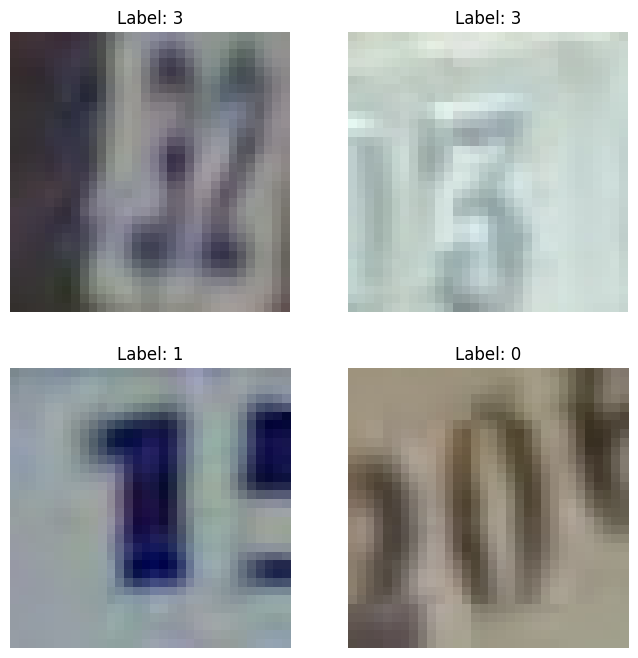

In [32]:
# Функция для отображения изображений
def imshow(img):
    img = img / 2 + 0.5  # Обратная нормализация
    plt.imshow(img.permute(1, 2, 0))  # Преобразование для отображения
    plt.axis('off')

# Отображение 4 изображений из батча
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    imshow(images[i])
    plt.title(f'Label: {labels[i].item()}')
plt.show()

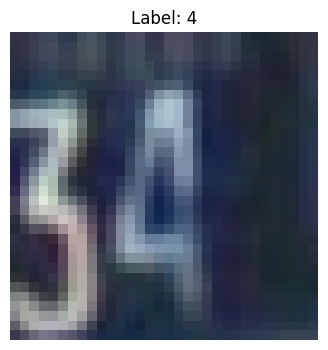

In [43]:
# Показ одного изображения
plt.figure(figsize=(4, 4))
imshow(images[0])
plt.title(f'Label: {labels[0].item()}')
plt.show()

In [44]:
# Показать тензор, как его видит компьютер
print("Тензор (изображение):", images[0])


Тензор (изображение): tensor([[[-0.5922, -0.5922, -0.5529,  ..., -0.6471, -0.6078, -0.5922],
         [-0.6078, -0.5843, -0.5373,  ..., -0.6627, -0.6078, -0.5922],
         [-0.6314, -0.6078, -0.5529,  ..., -0.6784, -0.6235, -0.5922],
         ...,
         [ 0.0431,  0.2941,  0.3176,  ..., -0.7569, -0.7569, -0.7098],
         [-0.2549,  0.0745,  0.3569,  ..., -0.6941, -0.6941, -0.6471],
         [-0.5373, -0.3961, -0.1765,  ..., -0.5608, -0.5686, -0.5451]],

        [[-0.6000, -0.5843, -0.5294,  ..., -0.6078, -0.5843, -0.5843],
         [-0.6078, -0.5765, -0.5137,  ..., -0.6235, -0.5922, -0.5843],
         [-0.6235, -0.5843, -0.5216,  ..., -0.6471, -0.5922, -0.5765],
         ...,
         [ 0.0431,  0.3098,  0.3333,  ..., -0.6235, -0.6235, -0.6000],
         [-0.2627,  0.0745,  0.3569,  ..., -0.5686, -0.5686, -0.5373],
         [-0.5529, -0.4118, -0.2000,  ..., -0.4745, -0.4824, -0.4824]],

        [[-0.4353, -0.4039, -0.3569,  ..., -0.5608, -0.5137, -0.4980],
         [-0.4510, -0.4

In [45]:
# 3. Определение архитектуры модели LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)  # Слой свертки
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Среднее подвыборки
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # Слой свертки
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Полносвязный слой
        self.fc2 = nn.Linear(120, 84)  # Полносвязный слой
        self.fc3 = nn.Linear(84, 10)  # Полносвязный слой (выход)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Применение ReLU к первому слою
        x = self.pool(x)  # Пуллинг
        x = F.relu(self.conv2(x))  # Применение ReLU ко второму слою
        x = self.pool(x)  # Пуллинг
        x = x.view(-1, 16 * 5 * 5)  # Преобразование тензора в вектор
        x = F.relu(self.fc1(x))  # Применение ReLU к полносвязному слою
        x = F.relu(self.fc2(x))  # Применение ReLU к полносвязному слою
        x = self.fc3(x)  # Выходной слой
        return x

model = LeNet5().to(device)

In [46]:
# 4. Оптимизация параметров
criterion = nn.CrossEntropyLoss()  # Функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор

In [47]:
# 5. Обучение модели
num_epochs = 5
train_losses = []  # Список для потерь обучения
test_accuracies = []  # Список для точности на тестовых данных

for epoch in range(num_epochs):
    model.train()  # Установка модели в режим обучения
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Перемещение данных на GPU

        optimizer.zero_grad()  # Обнуление градиентов
        outputs = model(images)  # Прямой проход
        loss = criterion(outputs, labels)  # Вычисление потерь
        loss.backward()  # Обратный проход
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()  # Накопление потерь

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Оценка на тестовых данных
    model.eval()  # Установка модели в режим оценки
    correct = 0
    total = 0
    with torch.no_grad():  # Отключение градиентов
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Прогноз классов
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Epoch [1/5], Loss: 0.9202
Accuracy of the model on the test images: 83.92%
Epoch [2/5], Loss: 0.4619
Accuracy of the model on the test images: 85.15%
Epoch [3/5], Loss: 0.3910
Accuracy of the model on the test images: 87.09%
Epoch [4/5], Loss: 0.3469
Accuracy of the model on the test images: 88.23%
Epoch [5/5], Loss: 0.3166
Accuracy of the model on the test images: 88.48%


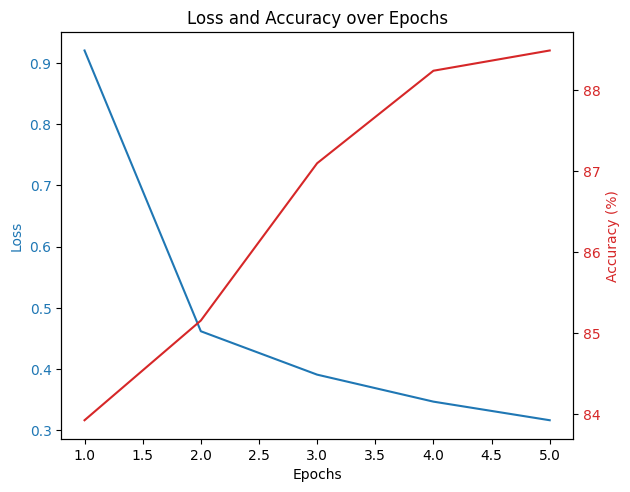

In [48]:
# 6. Визуализация результатов (графики потерь и точности)
fig, ax1 = plt.subplots()

# График потерь
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Создание второго оси для точности
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:red')
ax2.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  # Упаковка графиков
plt.title('Loss and Accuracy over Epochs')
plt.show()